<a href="https://colab.research.google.com/github/SiriosMEN/Data-science/blob/main/Steel_temperature_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Постановка задачи

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Задача**: построить модель, которая предскажет температуру стали.

### Критерии и метрики
Целевой признак: *****последняя измеренная температура*****.\
Метрика: MAE\
Критерии оценки
- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

## Исследовательский анализ данных

### Подготовка инструментов

In [ ]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [ ]:
print(lightgbm.__version__)

2.3.1


In [ ]:
dataset_names = ['data_arc','data_bulk','data_bulk_time','data_gas','data_temp','data_wire','data_wire_time']

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [ ]:
def analises(dataset,name):
    print('Таблица', name)
    
    display(dataset.info())
    display(dataset.head())
    display(dataset.describe())
    display(dataset.corr())
    dataset.hist(bins=100)

### Таблица data_arc - данные об электродах
А вернее - данные об электродуговом нагреве

Таблица data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021382,-0.004396
Активная мощность,-0.021382,1.000000,0.054437
Реактивная мощность,-0.004396,0.054437,1.000000


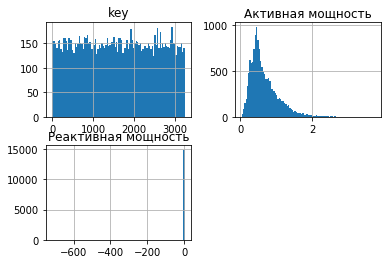

In [ ]:
analises(data_arc,"data_arc")

В таблице data_arc видим данные о потребляемой активной и реактивной мощности при электродуговом нагреве для каждой партии расплава (key), а также время включения и выключения нагрева. Очевидно, что мощность электродугового подгрева непосредственно влияет на температуру расплава. Однако для каждой партии нагрев включается несколько раз.
В таблице 14876 ненулевых значений по всем столбцам. Пропуски отсутствуют. Активная мощность распределена равномерно. А в реактивной мощности присутствует выброс в виде отрицательных значений.

In [ ]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


~~Наблюдается одно значение. Заменим отрицательное значение нулевым~~:
Заменим отрицательное значение медианным по партии:

In [ ]:
data_arc.loc[data_arc['Реактивная мощность'] < 0, 'Реактивная мощность'] = data_arc.loc[data_arc['key'] == int(data_arc[data_arc['Реактивная мощность'] < 0]['key'])]['Реактивная мощность'].median()

### Таблица data_bulk — данные о подаче сыпучих материалов (объём)

Таблица data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192066,-0.038643,-0.080335,-0.101955,-0.018074,-0.063539,-0.049425,NaN,0.262741,0.288135,-0.156748,-0.030981,0.050304,-0.149840,-0.169873
Bulk 1,-0.192066,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.038643,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.080335,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.101955,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.018074,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,-0.063539,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.049425,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.262741,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN


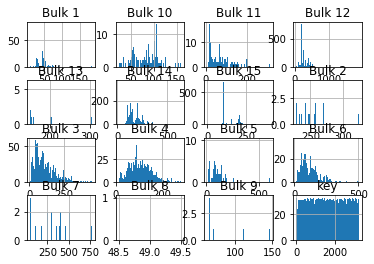

In [ ]:
analises(data_bulk,"data_bulk")

В таблице data_bulk представлены данные об объеме добавки сыпучих материалов, влияющих на процесс науглероживания и легирования.
Для разных партий применяется разный состав сыпучих материалов.
Возможно эти данные никак не влияют на предсказание температуры.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ок

### Таблица data_bulk_time — данные о подаче сыпучих материалов (время)

Таблица data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key
key,1.0


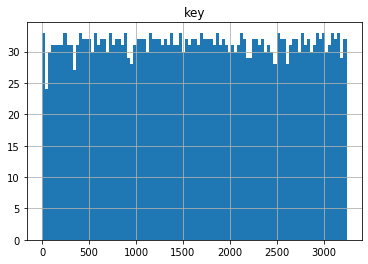

In [ ]:
analises(data_bulk_time,"data_bulk_time")

Представлены данные о времени подачи присадок в формате object. Скорее всего время присадки сыпучих материалов не влияет на температуру. Можно попробовать соотнести время присадки и время включения нагрева.

Поменяем тип признаков на время-дату

In [ ]:
for i in data_bulk_time.columns:
  if i != 'key':
    data_bulk_time['%s'%i] = pd.to_datetime(data_bulk_time['%s'%i],errors='coerce')

In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


### Таблица data_gas — данные о продувке сплава газом

Таблица data_gas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
key,1.000000,-0.040655
Газ 1,-0.040655,1.000000


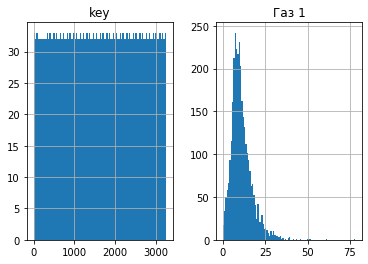

In [ ]:
analises(data_gas,"data_gas")

В таблице data_gas представлены некие значения по подаче инертного газа при плавке. Выбросмы в данных отсутствуют, данные распределены нормально.

### Таблица data_temp — результаты измерения температуры

Таблица data_temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Температура
key,1.000000,-0.046895
Температура,-0.046895,1.000000


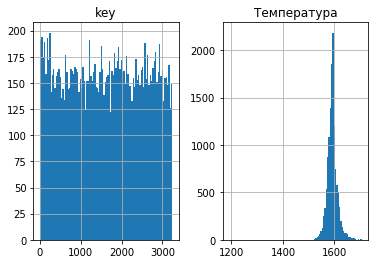

In [ ]:
analises(data_temp,"data_temp")

В таблице data_temp присутствует время замера и целевой признак исследования - температура расплава. Значения температуры присутствуют не для всех замеров, необходимо будет удалить строки с незаполненными значениями. Само значение температуры довольно узко распределено вокруг центрального значения. Замеры температуры для каждой партии проводятся несколько раз.

### Таблица data_wire — данные о проволочных материалах (объём)

Таблица data_wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083352,-0.005461,-0.084460,0.389064,NaN,0.082274,0.578898,0.323891,-0.012200
Wire 1,-0.083352,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.005461,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,-0.084460,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.389064,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.082274,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,0.578898,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.323891,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,-0.012200,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


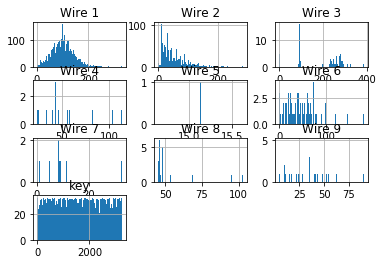

In [ ]:
analises(data_wire,"data_wire")

В таблице представлены данные об объеме подачи проволочных материалов. Проволочные материалы также как и сыпучие материалы подаются не для всех партий и не всегда. Влияют ли они на температуру?

### Таблица data_wire_time — данные о проволочных материалах (время)

Таблица data_wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key
key,1.0


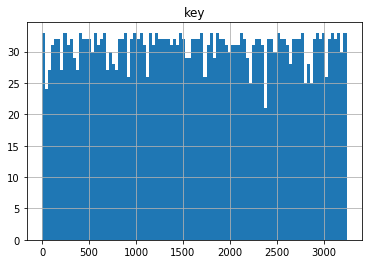

In [ ]:
analises(data_wire_time,"data_wire_time")

In [ ]:
for i in data_wire_time.columns:
  if i != 'key':
    data_wire_time['%s'%i] = pd.to_datetime(data_wire_time['%s'%i],errors='coerce')

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


В таблице представлены значения времени присадки проволочных материалов. При этом неизвестна продолжительность самой присадки.

## План работы

1. Выделить признак - длительность времени между первым и последним замерами температуры.
1. Выделить признак - первый замер температуры.
1. Преобразовать Начало и конец нагрева дугой в datestamp, добавить новый признак - длительность нагрева для каждой партии
2. Очистить столбец реактивная мощность от отрицательного значения.
3. Очистить таблицу с замерами температуры от пустых значений.
3. Очистить таблицу с замерами температуры от одинаковых значений начала и конца партии.
4. Преобразовать колонки с временем замера темературы в соответствующий формат datestamp.
5. Преобразовать колонки с временим присадки сыпучих и проволочных материалов в datestamp.
6. По номеру партии и по времени добавки супычих и проволочных материалов присоединить к таблице date_arc данные из объема сыпучих и проволочных материалов.
6. Добавить данные по газу.
7. По времени и номеру партии присоединить данные по замеру температуры.
8. Выделить целевой признак - последнюю температуру.
8. Разделить на обучающую и тестовую выборки. Стандартизировать данные.
9. Обучить модели, провести тестирование.
10. Выделить неважные признаки.

## Генерация признаков

### Целевой признак - последняя температура

In [ ]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
last_temperature = pd.DataFrame(data_temp.sort_values(by='Время замера',ascending=True).groupby('key',as_index=False)['Температура'].last())
last_temperature.rename(columns={'Температура':'Температура_последняя'},inplace=True)
print(last_temperature)

       key  Температура_последняя
0        1                 1613.0
1        2                 1602.0
2        3                 1599.0
3        4                 1625.0
4        5                 1602.0
...    ...                    ...
3211  3237                 1569.0
3212  3238                 1584.0
3213  3239                 1598.0
3214  3240                 1617.0
3215  3241                 1586.0

[3216 rows x 2 columns]


Проверим распределение температуры по партиям:

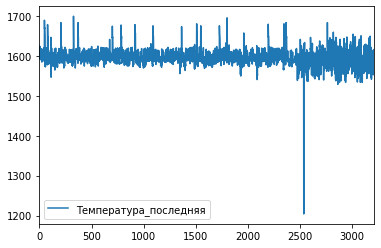

In [ ]:
last_temperature.plot(y='Температура_последняя');

Имеется один выброс. Удалим его из датасета:

In [ ]:
last_temperature = last_temperature.query('Температура_последняя > 1500')

### Значение первого замера температуры

In [ ]:
first_temperature = pd.DataFrame(data_temp.sort_values(by='Время замера',ascending=True).groupby('key',as_index=False)['Температура'].first())
first_temperature.rename(columns={'Температура':'Температура_первая'},inplace=True)
print(first_temperature)

       key  Температура_первая
0        1              1571.0
1        2              1581.0
2        3              1596.0
3        4              1601.0
4        5              1576.0
...    ...                 ...
3211  3237              1569.0
3212  3238              1584.0
3213  3239              1598.0
3214  3240              1617.0
3215  3241              1586.0

[3216 rows x 2 columns]


Посмотрим на распределение температуры:

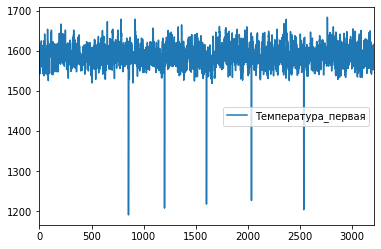

In [ ]:
first_temperature.plot(y='Температура_первая');

Имеется несколько необычных значений начальной температуры, соберем их и посмотрим на соседние замеры, являются ли они выбросами:

In [ ]:
outlayers = np.array(first_temperature[first_temperature['Температура_первая'] < 1500]['key'])

In [ ]:
for t in outlayers:
    display(data_temp[data_temp['key'] == t].sort_values(by='Время замера'))

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0


,key,Время замера,Температура
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0
5982,1214,2019-06-16 05:52:41,1608.0
5983,1214,2019-06-16 05:53:03,1608.0
5984,1214,2019-06-16 05:53:13,1608.0
5985,1214,2019-06-16 05:54:48,1604.0
5986,1214,2019-06-16 05:57:21,1604.0
5987,1214,2019-06-16 06:00:25,1604.0


,key,Время замера,Температура
7958,1619,2019-06-30 11:03:54,1218.0
7959,1619,2019-06-30 11:04:39,1623.0
7960,1619,2019-06-30 11:10:01,1611.0
7961,1619,2019-06-30 11:16:03,1603.0
7962,1619,2019-06-30 11:21:54,1590.0


,key,Время замера,Температура
10127,2052,2019-07-21 14:51:40,1227.0
10128,2052,2019-07-21 14:52:21,1592.0
10129,2052,2019-07-21 15:06:31,1590.0
10130,2052,2019-07-21 15:15:24,1591.0
10131,2052,2019-07-21 15:24:06,1592.0


,key,Время замера,Температура
12564,2561,2019-08-08 07:34:15,1204.0
12565,2561,2019-08-08 07:35:02,NaN
12566,2561,2019-08-08 07:35:38,NaN
12567,2561,2019-08-08 07:49:07,NaN
12568,2561,2019-08-08 07:54:21,NaN
12569,2561,2019-08-08 07:56:57,NaN


Видно, что в партиях, имеющих аномальные значения первых замеров следующие замеры, проведенные через несколько минут показывают значения намного выше. Можно признать данные значения выбросами.
Заменим выбросы ближайшими значениями по ряду:

In [ ]:
for t in outlayers:
    index = data_temp[data_temp['key'] == t].sort_values(by='Время замера').index[0]
    data_temp['Температура'][index] = data_temp['Температура'][index+1].copy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Повторно заполним таблицу с первой температурой:

In [ ]:
first_temperature = pd.DataFrame(data_temp.sort_values(by='Время замера',ascending=True).groupby('key',as_index=False)['Температура'].first())
first_temperature.rename(columns={'Температура':'Температура_первая'},inplace=True)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
идея понятна. но, как и говорил, аномалии в одних параметрах могут порождать аномалии в других.... Но мы этого не знаем. Одним из решений может быть - удалять всю строку с подозрительными значениями где-либо)

<div class="alert alert-info">
<font color='blue'> <b><u>КОММЕНТАРИЙ студента</u></b>
</font>

В таких вопросах я старась исходить из того, что удаление строки - это самый крайний вариант, когда уже совсем неоткуда взять данные. В данном случае при решении бизнес задачи модель будет меньше фэйлить если в будущих данных будут продолжать поступать аномалии. А так, если мы встроим анализ аномалий по первой температуре в продакшн, то при появлении на входе аномалии по первой температуре, будем брать вторую.
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
уловил)

### Длительность времени между первым и последним замером температуры.

In [ ]:
temp_measuring_duration = pd.DataFrame(data=(data_temp.groupby('key')['Время замера'].last() - data_temp.groupby('key')['Время замера'].first()))
print(temp_measuring_duration)

     Время замера
key              
1        00:14:21
2        00:21:45
3        00:21:40
4        00:06:28
5        00:12:42
...           ...
3237     00:21:39
3238     00:12:29
3239     00:52:28
3240     00:56:15
3241     00:34:38

[3216 rows x 1 columns]


нам потребуется вычислить время между последним замером и временем добавления присадок, добавим столбец с самим временем замера

In [ ]:
last_temp_measuring_time = pd.DataFrame(data=(data_temp.groupby('key',as_index=False)['Время замера'].last()))
last_temp_measuring_time.rename(columns={'Время замера':'Последнее_время_замера'},inplace=True)
print(last_temp_measuring_time)

       key Последнее_время_замера
0        1    2019-05-03 11:30:39
1        2    2019-05-03 11:59:12
2        3    2019-05-03 12:34:57
3        4    2019-05-03 12:59:25
4        5    2019-05-03 13:36:01
...    ...                    ...
3211  3237    2019-08-31 23:05:43
3212  3238    2019-08-31 23:43:00
3213  3239    2019-09-01 02:24:15
3214  3240    2019-09-01 03:35:16
3215  3241    2019-09-01 04:38:08

[3216 rows x 2 columns]


### Суммарное время нагрева для каждой партии

In [ ]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc['Длительность нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
electroheating =pd.DataFrame(data_arc.groupby('key')['Длительность нагрева'].sum())
print(electroheating)

     Длительность нагрева
key                      
1                00:18:18
2                00:13:31
3                00:10:55
4                00:12:21
5                00:14:29
...                   ...
3237             00:15:09
3238             00:09:06
3239             00:20:16
3240             00:13:59
3241             00:10:59

[3214 rows x 1 columns]


### Количество запусков нагрева

In [ ]:
electroheating['Количество включений'] = data_arc.groupby('key')['Длительность нагрева'].count()
print(electroheating)

     Длительность нагрева  Количество включений
key                                            
1                00:18:18                     5
2                00:13:31                     4
3                00:10:55                     5
4                00:12:21                     4
5                00:14:29                     4
...                   ...                   ...
3237             00:15:09                     5
3238             00:09:06                     3
3239             00:20:16                     8
3240             00:13:59                     5
3241             00:10:59                     5

[3214 rows x 2 columns]


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>хорошая идея с новыми факторами. Вопрос только в том - стоит ли их все тянуть в модель - не будет ли мультиколлинеарности....

### Суммарная мощность на партию

In [ ]:
active_power = data_arc.groupby('key',as_index=False)['Активная мощность','Реактивная мощность'].sum()
print(active_power)

       key  Активная мощность  Реактивная мощность
0        1           4.878147             3.183241
1        2           3.052598             1.998112
2        3           2.525882             1.599076
3        4           3.209250             2.060298
4        5           3.347173             2.252643
...    ...                ...                  ...
3209  3237           3.932467             2.828459
3210  3238           2.106529             1.681182
3211  3239           4.666754             3.111617
3212  3240           2.984083             2.483267
3213  3241           2.471447             1.696199

[3214 rows x 3 columns]


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ок

### Время добавления присадок

In [ ]:
bulk_wires_time = last_temp_measuring_time.merge(data_bulk_time,on='key').merge(data_wire_time,on='key')

In [ ]:
for i in bulk_wires_time.columns:
  if i != 'key' and i != 'Последнее_время_замера':
    bulk_wires_time['%s'%i] = bulk_wires_time['Последнее_время_замера'] - bulk_wires_time['%s'%i]
    bulk_wires_time['%s'%i] = bulk_wires_time['%s'%i].dt.seconds


In [ ]:
bulk_wires_time.drop(['Последнее_время_замера'],axis='columns',inplace=True)

In [ ]:
bulk_wires_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 3024
Data columns (total 25 columns):
key        3025 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1293 non-null float64
Bulk 4     1013 non-null float64
Bulk 5     77 non-null float64
Bulk 6     572 non-null float64
Bulk 7     24 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2358 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2711 non-null float64
Bulk 15    2236 non-null float64
Wire 1     3000 non-null float64
Wire 2     1051 non-null float64
Wire 3     63 non-null float64
Wire 4     14 non-null float64
Wire 5     1 non-null float64
Wire 6     73 non-null float64
Wire 7     11 non-null float64
Wire 8     19 non-null float64
Wire 9     25 non-null float64
dtypes: float64(24), int64(1)
memory usage: 614.5 KB


### Создание сводной таблицы признаков

In [ ]:
pivot_data = last_temperature.merge(first_temperature,on='key').merge(temp_measuring_duration,on='key').merge(electroheating, on='key').merge(active_power,on='key').merge(data_gas,on='key').merge(bulk_wires_time,on='key').merge(data_wire,on='key').merge(data_bulk,on='key')

print(pivot_data)

       key  Температура_последняя  Температура_первая Время замера  \
0        1                 1613.0              1571.0     00:14:21   
1        2                 1602.0              1581.0     00:21:45   
2        3                 1599.0              1596.0     00:21:40   
3        4                 1625.0              1601.0     00:06:28   
4        5                 1602.0              1576.0     00:12:42   
...    ...                    ...                 ...          ...   
3016  3237                 1569.0              1569.0     00:21:39   
3017  3238                 1584.0              1584.0     00:12:29   
3018  3239                 1598.0              1598.0     00:52:28   
3019  3240                 1617.0              1617.0     00:56:15   
3020  3241                 1586.0              1586.0     00:34:38   

     Длительность нагрева  Количество включений  Активная мощность  \
0                00:18:18                     5           4.878147   
1                00

Заменим для длительности замера и нагрева тип данных:

In [ ]:
pivot_data['Время замера'] = pivot_data['Время замера'].dt.seconds
pivot_data['Длительность нагрева'] = pivot_data['Длительность нагрева'].dt.seconds

Избавимся от партий с совпадающими замерами вначале и в конце:

In [ ]:
pivot_data = pivot_data.loc[pivot_data['Температура_первая'] != pivot_data['Температура_последняя']]

Заполним отсутствующие значения нулями:

In [ ]:
pivot_data = pivot_data.fillna(0)

Проведем общий анализ полученной таблицы

In [ ]:
pivot_data

,key,Температура_последняя,Температура_первая,Время замера,Длительность нагрева,Количество включений,Активная мощность,Реактивная мощность,Газ 1,Bulk 1_x,...,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y
0,1,1613.0,1571.0,861,1098,5,4.878147,3.183241,29.749986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1602.0,1581.0,1305,811,4,3.052598,1.998112,12.555561,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1599.0,1596.0,1300,655,5,2.525882,1.599076,28.554793,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1625.0,1601.0,388,741,4,3.209250,2.060298,18.841219,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1602.0,1576.0,762,869,4,3.347173,2.252643,5.413692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1591.0,1570.0,1137,723,4,3.210690,2.360777,7.125735,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2325,2496,1591.0,1554.0,1618,940,6,4.203064,2.810185,9.412616,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2326,2497,1589.0,1571.0,717,569,3,2.212379,1.851269,6.271699,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2327,2498,1594.0,1591.0,1302,750,5,3.408725,2.355428,14.953657,0.0,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


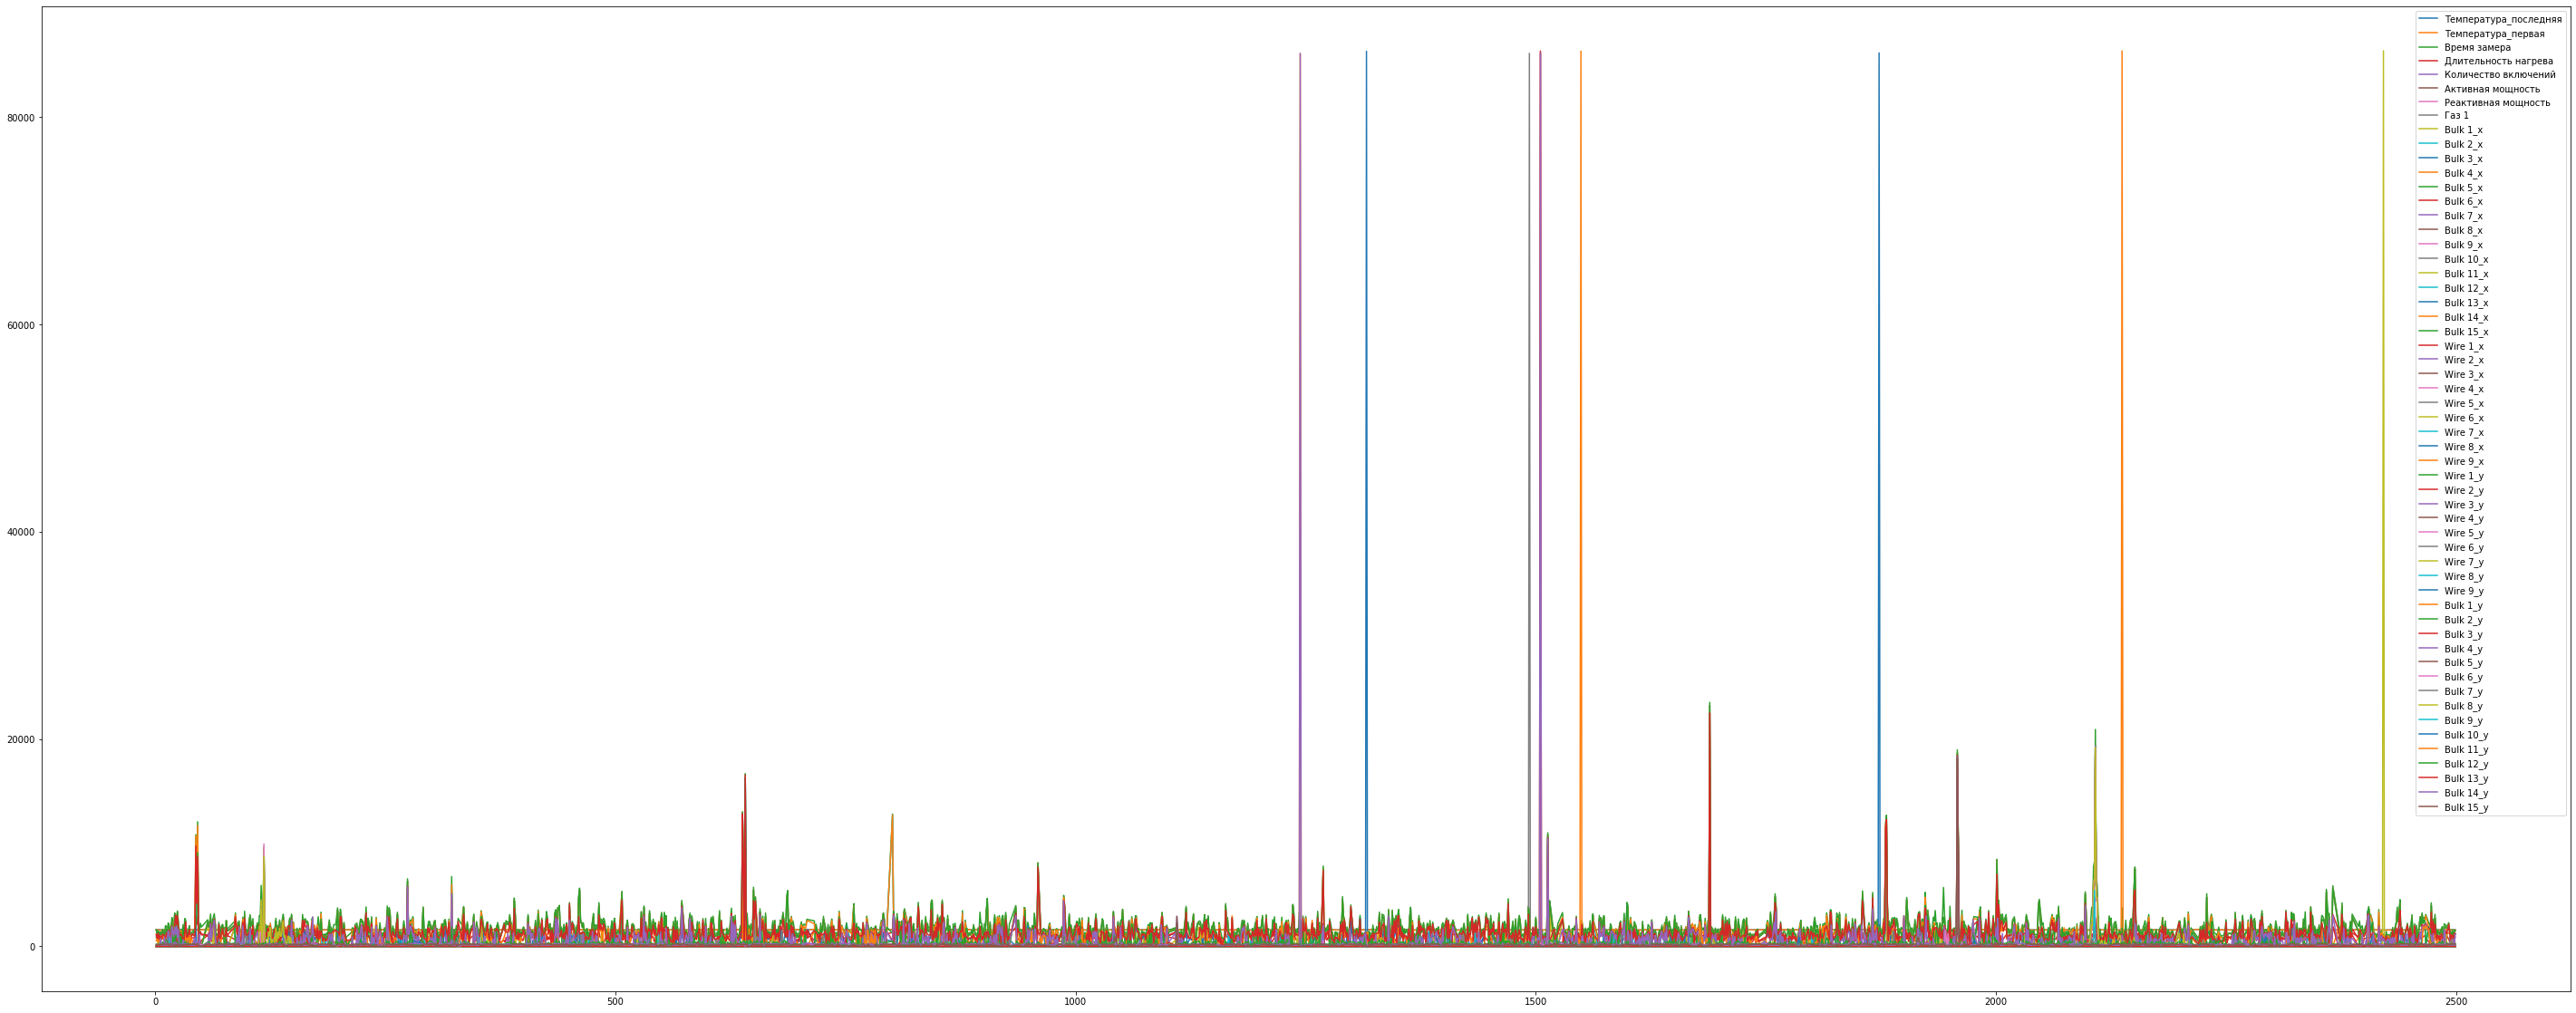

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(pivot_data['key'],pivot_data.iloc[:,1:])
plt.legend(pivot_data.iloc[:,1:])
plt.show()

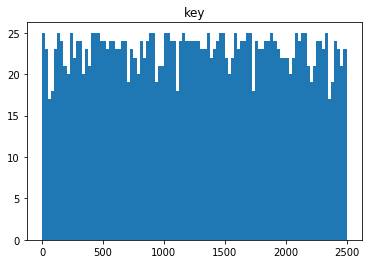

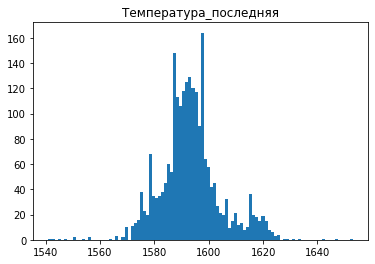

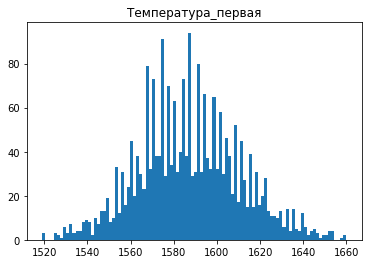

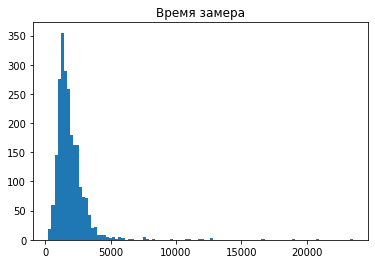

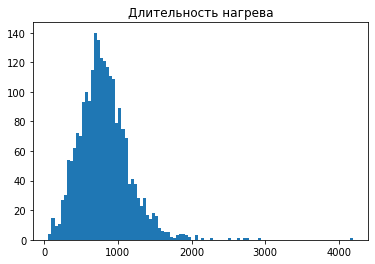

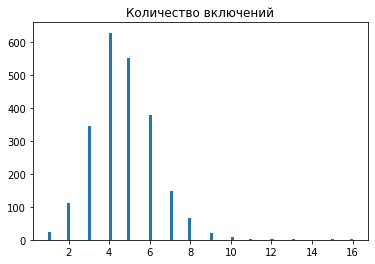

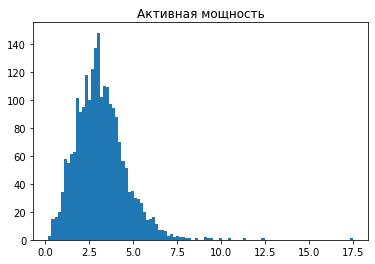

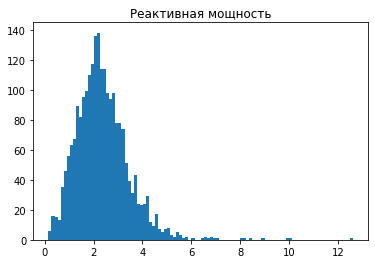

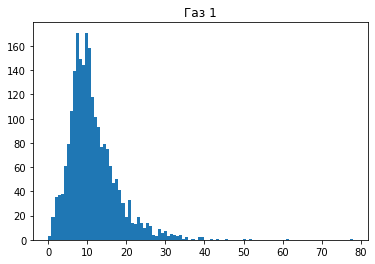

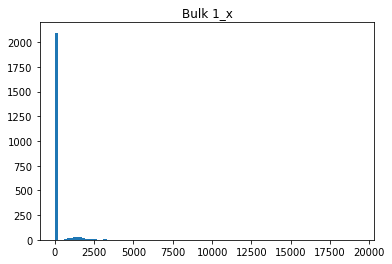

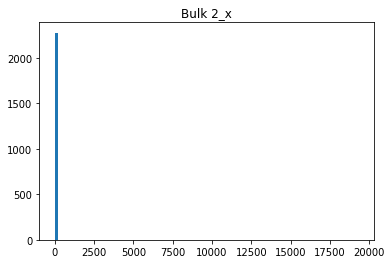

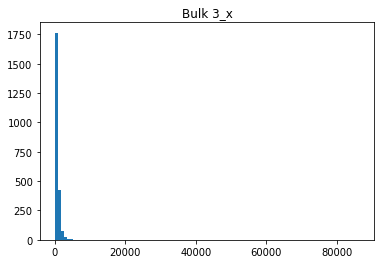

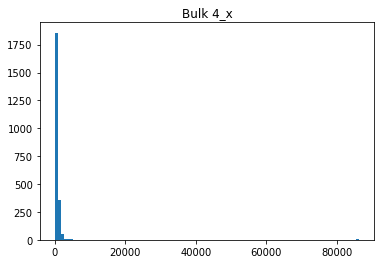

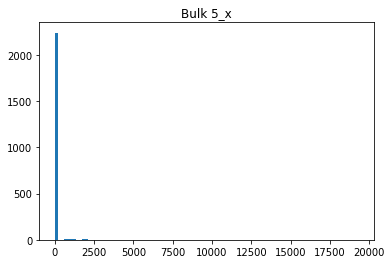

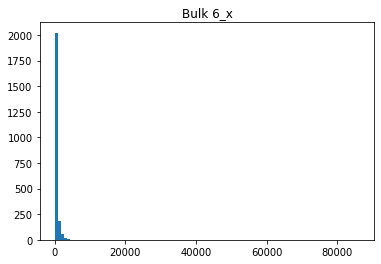

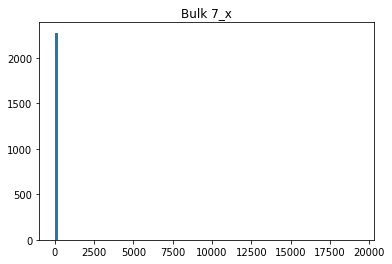

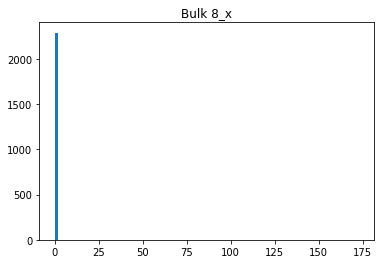

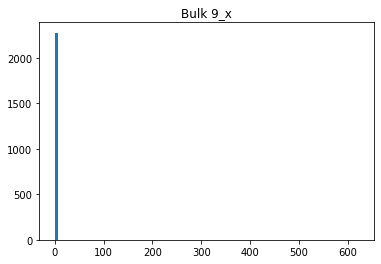

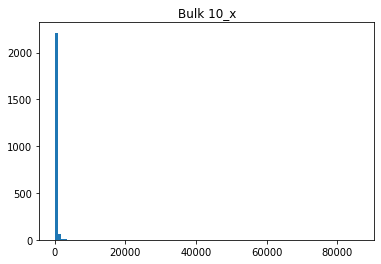

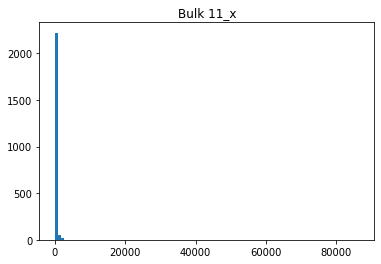

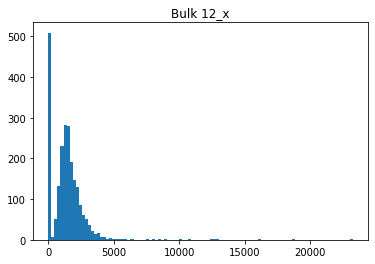

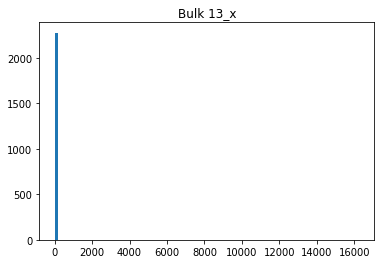

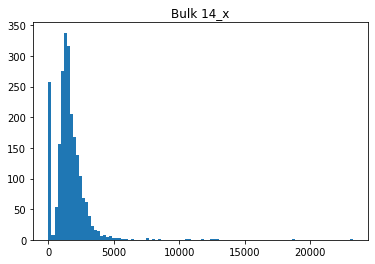

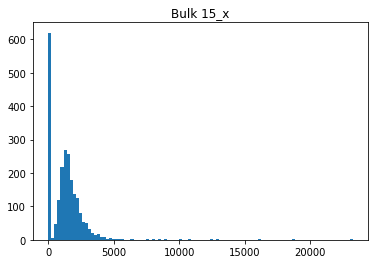

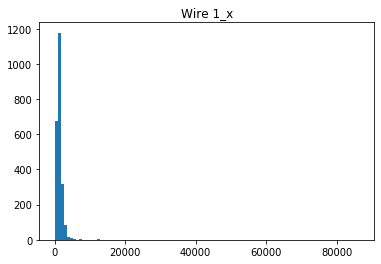

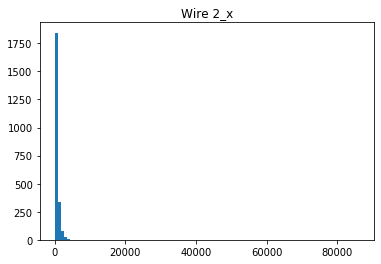

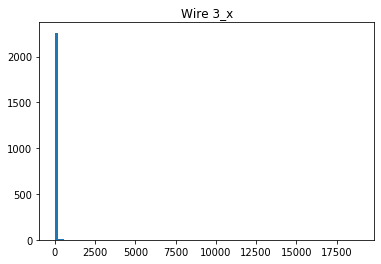

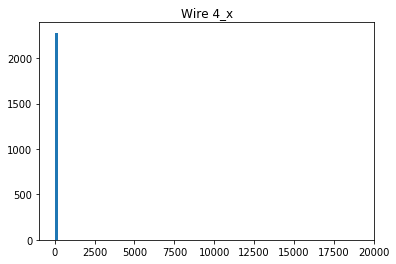

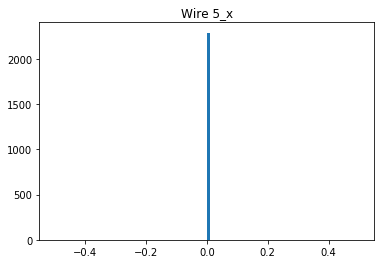

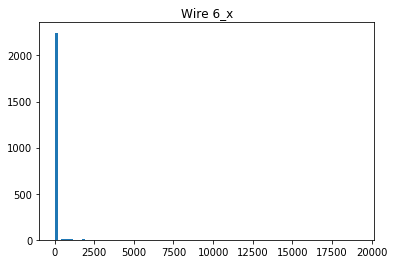

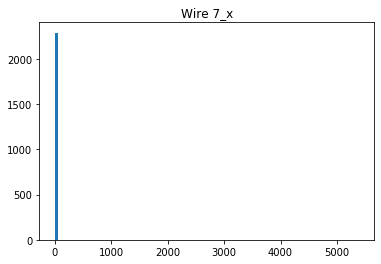

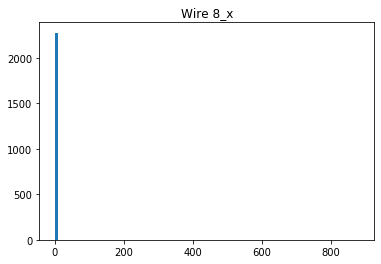

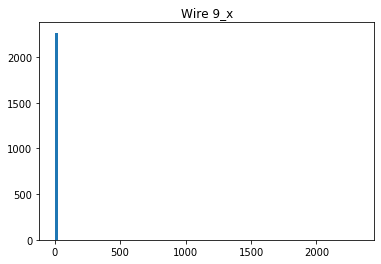

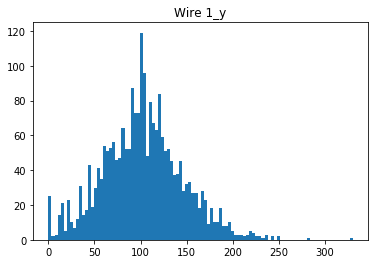

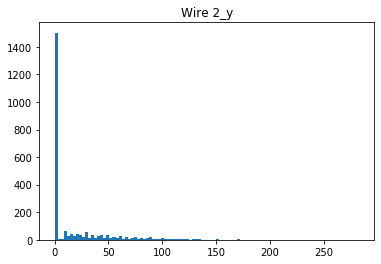

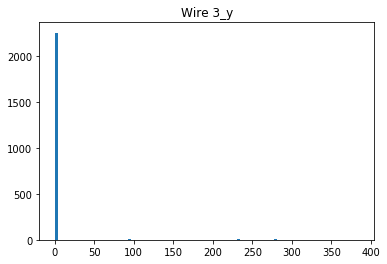

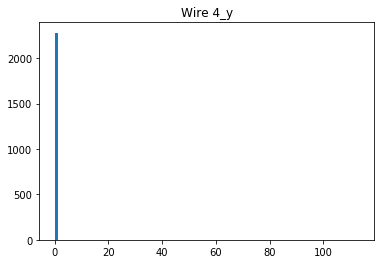

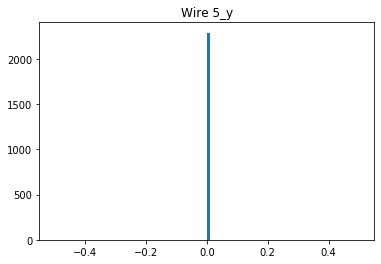

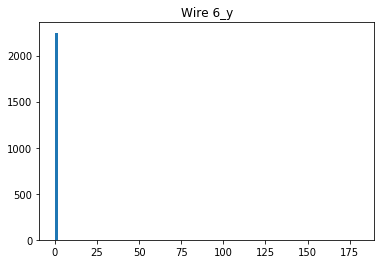

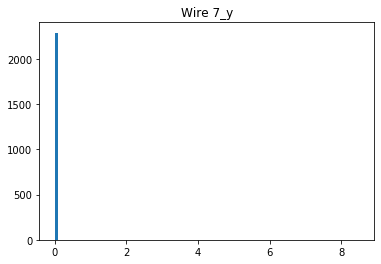

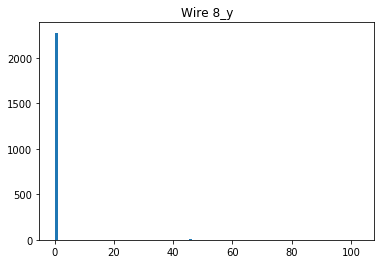

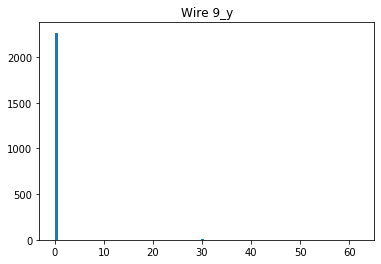

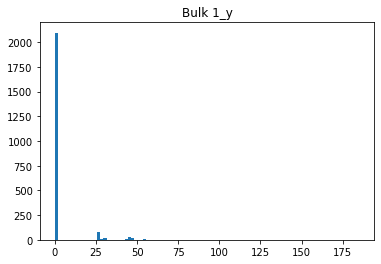

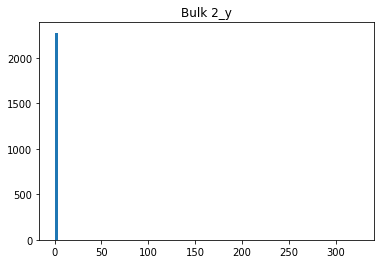

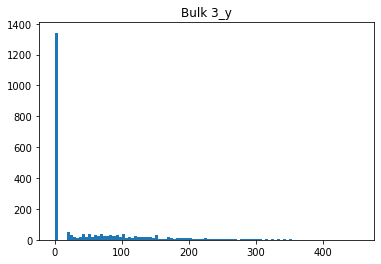

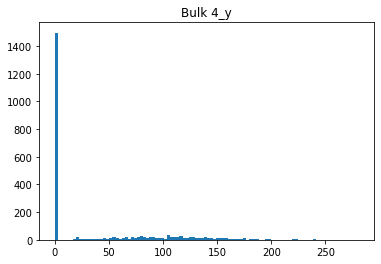

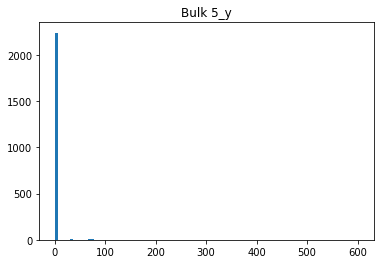

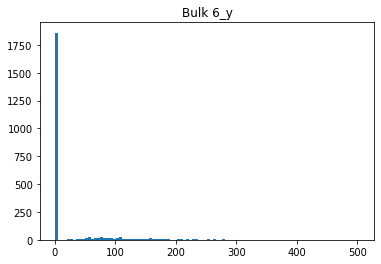

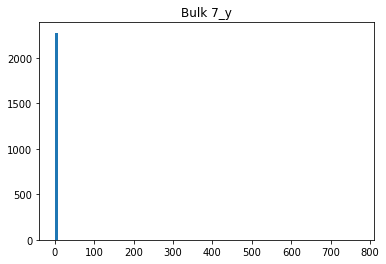

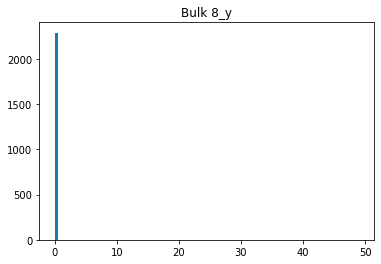

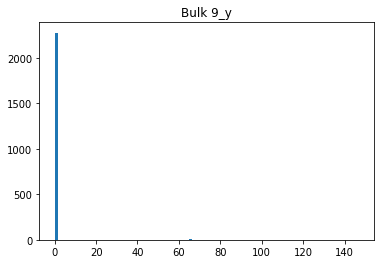

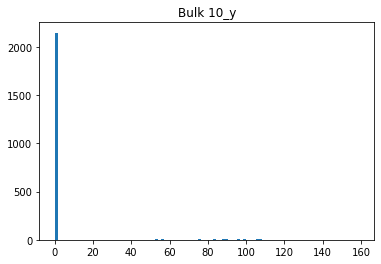

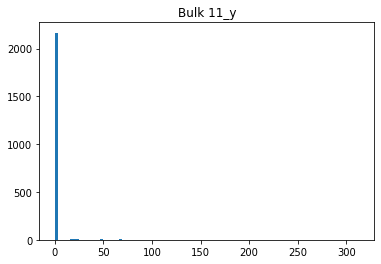

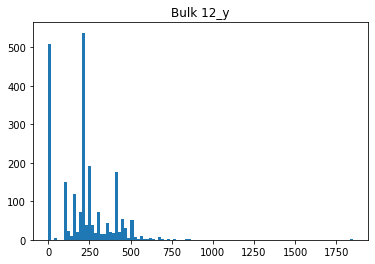

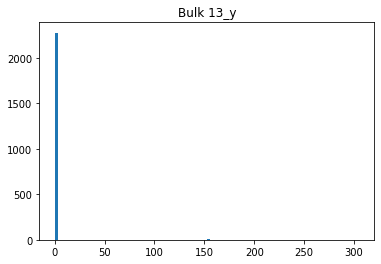

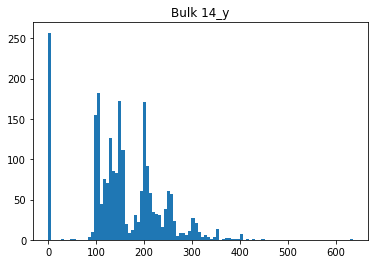

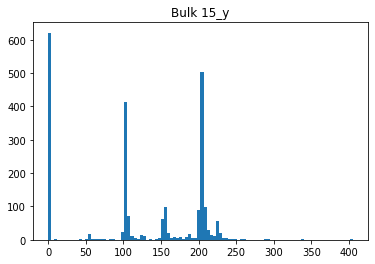

In [ ]:
for i in pivot_data.columns:
  plt.hist(bins=100,x=pivot_data['%s'%i])
  plt.title('%s'%i)
  plt.show()

Многие значения имеют сильно разреженное распределение. Посмотрим на важность признаков в процессе моделирования.

In [ ]:
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2328
Data columns (total 57 columns):
key                      2292 non-null int64
Температура_последняя    2292 non-null float64
Температура_первая       2292 non-null float64
Время замера             2292 non-null int64
Длительность нагрева     2292 non-null int64
Количество включений     2292 non-null int64
Активная мощность        2292 non-null float64
Реактивная мощность      2292 non-null float64
Газ 1                    2292 non-null float64
Bulk 1_x                 2292 non-null float64
Bulk 2_x                 2292 non-null float64
Bulk 3_x                 2292 non-null float64
Bulk 4_x                 2292 non-null float64
Bulk 5_x                 2292 non-null float64
Bulk 6_x                 2292 non-null float64
Bulk 7_x                 2292 non-null float64
Bulk 8_x                 2292 non-null float64
Bulk 9_x                 2292 non-null float64
Bulk 10_x                2292 non-null float64
Bulk 11_

In [ ]:
correlation = pivot_data.corr()
display(correlation)

,key,Температура_последняя,Температура_первая,Время замера,Длительность нагрева,Количество включений,Активная мощность,Реактивная мощность,Газ 1,Bulk 1_x,...,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y
key,1.000000,-0.101490,-0.018283,-0.001640,-0.030411,-0.033973,-0.030126,0.005788,-0.044232,-0.020835,...,0.008076,0.052988,0.015688,-0.039728,0.062189,0.038138,0.026818,-0.015618,-0.111886,-0.044507
Температура_последняя,-0.101490,1.000000,0.295912,0.093744,0.275868,0.178774,0.288611,0.238596,0.058043,-0.092159,...,-0.179661,-0.108357,-0.026856,-0.016263,0.061679,-0.110528,0.265241,-0.011058,0.113141,0.266341
Температура_первая,-0.018283,0.295912,1.000000,0.208729,-0.390481,-0.181401,-0.440655,-0.414211,0.036351,0.129878,...,-0.125375,0.088151,-0.011699,-0.033232,0.035994,-0.110447,-0.083509,0.020514,-0.183371,-0.065191
Время замера,-0.001640,0.093744,0.208729,1.000000,0.563085,0.585048,0.535700,0.537842,0.454870,0.360922,...,0.150868,0.246051,-0.004737,-0.014831,-0.001972,0.035600,0.218013,0.266696,0.183257,0.128731
Длительность нагрева,-0.030411,0.275868,-0.390481,0.563085,1.000000,0.798299,0.978087,0.965337,0.397064,0.170036,...,0.163864,0.084885,-0.011462,0.012704,-0.013239,0.085492,0.464737,0.129796,0.461098,0.294978
Количество включений,-0.033973,0.178774,-0.181401,0.585048,0.798299,1.000000,0.759534,0.754231,0.404703,0.206607,...,0.155043,0.153241,-0.009084,0.038267,0.007427,0.066934,0.305074,0.118236,0.334712,0.172638
Активная мощность,-0.030126,0.288611,-0.440655,0.535700,0.978087,0.759534,1.000000,0.958201,0.374168,0.156773,...,0.155198,0.074566,-0.011594,0.023497,-0.003990,0.078126,0.475984,0.122868,0.465036,0.333161
Реактивная мощность,0.005788,0.238596,-0.414211,0.537842,0.965337,0.754231,0.958201,1.000000,0.356702,0.192664,...,0.145449,0.101365,-0.008499,0.010867,-0.011227,0.083702,0.454542,0.117194,0.429717,0.295611
Газ 1,-0.044232,0.058043,0.036351,0.454870,0.397064,0.404703,0.374168,0.356702,1.000000,0.286695,...,0.140821,0.199380,0.004077,0.117082,-0.009925,0.041888,0.215539,0.049100,0.268924,0.038962
Bulk 1_x,-0.020835,-0.092159,0.129878,0.360922,0.170036,0.206607,0.156773,0.192664,0.286695,1.000000,...,-0.023068,0.475797,-0.004679,-0.016146,-0.019389,-0.030566,0.205853,-0.005601,0.095992,-0.006408


Рассмотрим поближе сильно коррелирующие признаки:

In [ ]:
strong_cor = []
for i in correlation.index:
  if i not in strong_cor:
    for c in correlation.columns:
      if 1 > correlation.loc[i,c] > 0.90:
        print (c,'коррелирует с ',i, 'с коэффициентом', correlation.loc[i,c])
        if c not in strong_cor:
          strong_cor.append(c)

Активная мощность коррелирует с  Длительность нагрева с коэффициентом 0.9780868406585301
Реактивная мощность коррелирует с  Длительность нагрева с коэффициентом 0.9653368422263231
Bulk 5_x коррелирует с  Bulk 2_x с коэффициентом 0.9438678059025764
Wire 4_x коррелирует с  Bulk 2_x с коэффициентом 0.9796212658799857
Wire 6_x коррелирует с  Bulk 2_x с коэффициентом 0.9657141979526542
Wire 1_x коррелирует с  Bulk 6_x с коэффициентом 0.9039909805210583
Wire 8_x коррелирует с  Bulk 9_x с коэффициентом 0.9321748976144033
Wire 8_y коррелирует с  Bulk 9_x с коэффициентом 0.933452667288288
Bulk 9_y коррелирует с  Bulk 9_x с коэффициентом 0.9188427560421878
Bulk 15_x коррелирует с  Bulk 12_x с коэффициентом 0.921393874497063
Wire 7_y коррелирует с  Wire 7_x с коэффициентом 0.9176913877222548


Активная и реактивная мощности коррелируют с длительностью нагрева, а значит и друг с другом. В реальном бизнес - кейсе это надо выяснить на месте, поскольку мощность и длительность не должны быть связаны. Однако здесь очень высокая корреляция.
Другие коррелирующие признаки - информация о присадках. Думаю, что эта корреляция связана с технологическим процессом. Например для определенной марки стали всегда используется строго одинаковое количество углерода, легирующих элементов, других присадок.

Удалим сильно коррелирующие признаки

In [ ]:
print('Удаляем следующие признаки:', strong_cor)
pivot_data.drop(strong_cor,axis='columns',inplace=True)

Удаляем следующие признаки: ['Активная мощность', 'Реактивная мощность', 'Bulk 5_x', 'Wire 4_x', 'Wire 6_x', 'Wire 1_x', 'Wire 8_x', 'Wire 8_y', 'Bulk 9_y', 'Bulk 15_x', 'Wire 7_y']


Специально для LGBM поменяем названия колонок написанных кириллицей

In [ ]:
pivot_data.columns

Index(['key', 'Температура_последняя', 'Температура_первая', 'Время замера',
       'Длительность нагрева', 'Количество включений', 'Газ 1', 'Bulk 1_x',
       'Bulk 2_x', 'Bulk 3_x', 'Bulk 4_x', 'Bulk 6_x', 'Bulk 7_x', 'Bulk 8_x',
       'Bulk 9_x', 'Bulk 10_x', 'Bulk 11_x', 'Bulk 12_x', 'Bulk 13_x',
       'Bulk 14_x', 'Wire 2_x', 'Wire 3_x', 'Wire 5_x', 'Wire 7_x', 'Wire 9_x',
       'Wire 1_y', 'Wire 2_y', 'Wire 3_y', 'Wire 4_y', 'Wire 5_y', 'Wire 6_y',
       'Wire 9_y', 'Bulk 1_y', 'Bulk 2_y', 'Bulk 3_y', 'Bulk 4_y', 'Bulk 5_y',
       'Bulk 6_y', 'Bulk 7_y', 'Bulk 8_y', 'Bulk 10_y', 'Bulk 11_y',
       'Bulk 12_y', 'Bulk 13_y', 'Bulk 14_y', 'Bulk 15_y'],
      dtype='object')

In [ ]:
pivot_data.rename({'Температура_последняя':'Last_temp','Температура_первая':'First_temp','Время замера':'Measuring_time','Длительность нагрева':'Heating_time','Количество включений':'Power_times','Газ 1':'Gas'},axis='columns',inplace=True)

### Выделение признаков, целевого признака, разделение на обучающую и тестовую выборки

In [ ]:
target = pivot_data['Last_temp']
features = pivot_data.drop(['Last_temp','key'],axis='columns')
print(features.shape)
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.25,random_state=1234)

(2292, 44)


### Масштабирование признаков

In [ ]:
scaler = StandardScaler(with_mean=False)  
scaler.fit(features_train)  
features_train = scaler.transform(features_train)  
features_test = scaler.transform(features_test)

## Моделирование

In [ ]:
def modeling(model,model_type,features_test,target_test,**kwargs):
    model=model
    model.fit(**kwargs)
    predicts = model.predict(features_test)
    MAE = mean_absolute_error(target_test,predicts)
    print('MAE на алгоритме',model_type,'=',MAE)
    return MAE, model

### Случайный лес

In [ ]:
MAE_RFR,model_rfr = modeling(RandomForestRegressor(random_state=12345,n_estimators=200,max_depth=100,n_jobs=-1),'случайный лес',features_test,target_test,X=features_train,y=target_train)

MAE на алгоритме случайный лес = 5.699188481675391


### Оценка важности признаков для случайного леса

Важность признаков:


,Признак,Важность
0,First_temp,0.185701
1,Heating_time,0.178176
2,Wire 1_y,0.087205
3,Measuring_time,0.052741
4,Gas,0.042240
5,Bulk 12_y,0.038284
6,Bulk 14_y,0.037889
7,Bulk 6_y,0.037877
8,Bulk 6_x,0.036931
9,Wire 2_y,0.036467


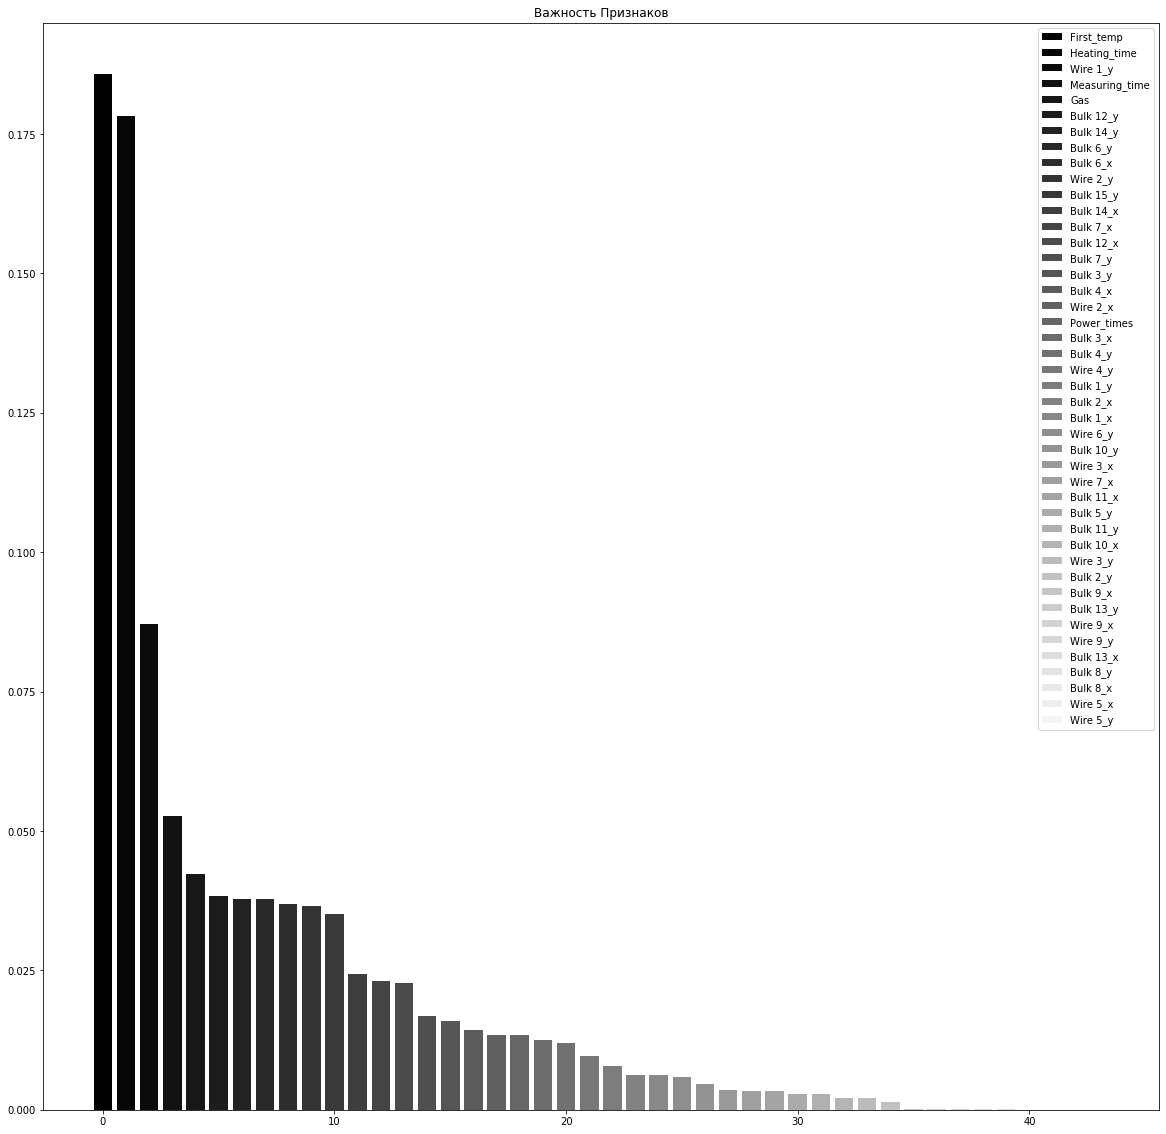

In [ ]:
importances = model_rfr.feature_importances_
feature_importances = pd.DataFrame({'Признак': list(features.columns),'Важность': importances}).sort_values(by='Важность',ascending=False).reset_index(drop=True)

print("Важность признаков:")
display(feature_importances)
plt.figure(figsize=(20,20))
plt.title(u"Важность Признаков")
bars = plt.bar(range(len(feature_importances)),feature_importances['Важность'],color=([str(i/float(len(feature_importances['Признак'])+1)) for i in range(len(feature_importances['Признак']))]))
plt.legend(bars, feature_importances['Признак']);

Для нескольких признаков наблюдается резкий спад важности. Избавимся от неважных признаков:

In [ ]:
not_important_features = feature_importances.loc[feature_importances['Важность'] < feature_importances['Важность'].quantile(0.10)]
features = features.drop(list(not_important_features['Признак'].values),axis='columns')
print(features.shape)

(2292, 39)


Заново разделим выборку и стандартизируем данные:

In [ ]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.25,random_state=1234)
scaler = StandardScaler(with_mean=False)  
scaler.fit(features_train)  
features_train = scaler.transform(features_train)  
features_test = scaler.transform(features_test)

In [ ]:
MAE_RFR,model_rfr = modeling(RandomForestRegressor(random_state=12345,n_estimators=200,max_depth=100,n_jobs=-1),'случайный лес',features_test,target_test,X=features_train,y=target_train)

MAE на алгоритме случайный лес = 5.698394415357768


### Катбуст

In [ ]:
model_catboost = CatBoostRegressor(loss_function='MAE',iterations=300)
grid = {'learning_rate':[0.1,0.5,0.75],'depth':range(5,10)}
grid_results = model_catboost.grid_search(grid,X=features,y=target,cv=5,verbose=2)

0:	loss: 7.3253199	best: 7.3253199 (0)	total: 4.49s	remaining: 1m 2s
2:	loss: 7.1455878	best: 7.1455878 (2)	total: 13s	remaining: 51.9s
4:	loss: 6.9232514	best: 6.9232514 (4)	total: 24.3s	remaining: 48.6s
6:	loss: 11.6864846	best: 6.9232514 (4)	total: 38.1s	remaining: 43.5s
8:	loss: 7.4658621	best: 6.9232514 (4)	total: 54.1s	remaining: 36.1s
10:	loss: 8.2498488	best: 6.9232514 (4)	total: 1m 19s	remaining: 28.8s
12:	loss: 15.1959252	best: 6.9232514 (4)	total: 1m 52s	remaining: 17.4s
14:	loss: 9.1839920	best: 6.9232514 (4)	total: 2m 36s	remaining: 0us
Estimating final quality...


In [ ]:
print(grid_results['params'])
print(model_catboost.get_best_score())

{'depth': 6, 'learning_rate': 0.5}
{'learn': {'MAE': 2.395229163583443}}


In [ ]:
MAE_CB,model_cb = modeling(CatBoostRegressor(loss_function='MAE',iterations=300,depth=grid_results['params']['depth'],learning_rate=grid_results['params']['learning_rate'],verbose=2),'CatBoost',features_test,target_test,X=features_train,y=target_train)

0:	learn: 7.3202434	total: 3.41ms	remaining: 1.02s
2:	learn: 6.4994901	total: 9.16ms	remaining: 907ms
4:	learn: 6.1418330	total: 62ms	remaining: 3.66s
6:	learn: 5.8279150	total: 67.9ms	remaining: 2.84s
8:	learn: 5.6386357	total: 72ms	remaining: 2.33s
10:	learn: 5.4690967	total: 161ms	remaining: 4.23s
12:	learn: 5.3339272	total: 167ms	remaining: 3.69s
14:	learn: 5.1577997	total: 173ms	remaining: 3.29s
16:	learn: 4.9773622	total: 264ms	remaining: 4.39s
18:	learn: 4.8005765	total: 270ms	remaining: 3.99s
20:	learn: 4.6104223	total: 359ms	remaining: 4.77s
22:	learn: 4.4870990	total: 364ms	remaining: 4.38s
24:	learn: 4.3793455	total: 374ms	remaining: 4.12s
26:	learn: 4.3028570	total: 459ms	remaining: 4.64s
28:	learn: 4.2287621	total: 466ms	remaining: 4.35s
30:	learn: 4.1580349	total: 555ms	remaining: 4.82s
32:	learn: 4.1057511	total: 560ms	remaining: 4.53s
34:	learn: 4.0501742	total: 571ms	remaining: 4.32s
36:	learn: 4.0066646	total: 654ms	remaining: 4.65s
38:	learn: 3.9523261	total: 658ms	r

### Линейная регрессия

In [ ]:
MAE_LR,model_lr = modeling(LinearRegression(normalize=False,n_jobs=-1),'линейная регрессия',features_test,target_test,X=features_train,y=target_train)

MAE на алгоритме линейная регрессия = 5.926300495179816


In [ ]:
MAE_Ridge,model_ridge = modeling(Ridge(normalize=True,random_state=12345,alpha=0.0001,solver='auto'),'Ridge',features_test,target_test,X=features_train,y=target_train)

MAE на алгоритме Ridge = 5.925441981948057


In [ ]:
MAE_Lasso,model_lasso = modeling(Lasso(normalize=True,random_state=12345,alpha=0.0001),'Ridge',features_test,target_test,X=features_train,y=target_train)

MAE на алгоритме Ridge = 5.916103840216004


In [ ]:

model_LGBM = LGBMRegressor(random_state=12345)
grid_LGBM = {'learning_rate':[0.001,0.01,0.03,0.05,0.08,0.5]}
regressor_LGBM = GridSearchCV(estimator=model_LGBM,param_grid=grid_LGBM,verbose=2,cv=5,scoring='neg_mean_absolute_error')
regressor_LGBM.fit(X=features,y=target)
print(regressor_LGBM.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.001 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. learning_rate=0.001, total= 4.6min
[CV] learning_rate=0.001 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s


[CV] .............................. learning_rate=0.001, total= 4.3min
[CV] learning_rate=0.001 .............................................
[CV] .............................. learning_rate=0.001, total=   1.7s
[CV] learning_rate=0.001 .............................................
[CV] .............................. learning_rate=0.001, total=   1.5s
[CV] learning_rate=0.001 .............................................
[CV] .............................. learning_rate=0.001, total=   1.4s
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total=   1.6s
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total=   1.6s
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total=   1.5s
[CV] learning_rate=0.01 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.6min finished


{'learning_rate': 0.05}


In [ ]:
MAE_LGBM,model_lgbmregressor = modeling(LGBMRegressor(learning_rate=regressor_LGBM.best_params_['learning_rate'],random_state=12345),'LightGBM',features_test,target_test,X=features_train,y=target_train)

MAE на алгоритме LightGBM = 5.379250228972025


### MLPRegressor

In [ ]:
# model_MLPR = MLPRegressor(hidden_layer_sizes=(100,100,50 ),random_state=12345,verbose=2,max_iter=3000,learning_rate_init=0.0001,tol=0.1,warm_start=True,early_stopping=True,solver='adam')
# grid_MLP = {'activation' : ['identity', 'tanh', 'relu'], 'learning_rate' : ['constant', 'invscaling', 'adaptive']}
# regressor = GridSearchCV(estimator=model_MLPR,param_grid = grid_MLP,verbose=2,cv=5)
# #regressor = RandomizedSearchCV(estimator = model_MLPR, param_distributions = grid_MLP, n_jobs=-1,scoring ='neg_mean_absolute_error')

# regressor.fit(X=features,y=target)
# print(regressor.best_estimator_)
# predictions=regressor.predict(features_test)
# MAE = mean_absolute_error(target_test,predictions)
# print('MAE на алгоритме''=',MAE)

In [ ]:
MAE_MLPR,model_mlpregressor = modeling(MLPRegressor(hidden_layer_sizes=(500,300,80,70,60 ),activation = 'identity',solver='adam',random_state=12345,verbose=2,max_iter=5000,learning_rate_init=0.00001,learning_rate='adaptive',tol=0.1),'MLPRegressor',features_test,target_test,X=features_train,y=target_train)

Iteration 1, loss = 1294504.20917855
Iteration 2, loss = 1281357.26141970
Iteration 3, loss = 1268286.15229778
Iteration 4, loss = 1255224.94325209
Iteration 5, loss = 1242104.24323656
Iteration 6, loss = 1228827.65082213
Iteration 7, loss = 1215329.05705197
Iteration 8, loss = 1201538.21438037
Iteration 9, loss = 1187390.02225093
Iteration 10, loss = 1172839.08500426
Iteration 11, loss = 1157825.40296437
Iteration 12, loss = 1142309.18336300
Iteration 13, loss = 1126241.86203834
Iteration 14, loss = 1109595.44164591
Iteration 15, loss = 1092326.17753953
Iteration 16, loss = 1074397.10138135
Iteration 17, loss = 1055796.91705736
Iteration 18, loss = 1036488.17619215
Iteration 19, loss = 1016459.12844232
Iteration 20, loss = 995690.18311186
Iteration 21, loss = 974174.91072010
Iteration 22, loss = 951901.75681976
Iteration 23, loss = 928863.23968344
Iteration 24, loss = 905067.44033372
Iteration 25, loss = 880519.46278167
Iteration 26, loss = 855224.61963130
Iteration 27, loss = 829203.

In [ ]:
#В этой ячейке проводился поиск оптимальных параметров
# model_GBR = GradientBoostingRegressor(n_estimators = 200,criterion = 'mae',verbose=2)
# grid_GBR = {'loss': [ 'lad', 'quantile'], 'learning_rate' : [0.01,0.1,0.5],'max_depth': range(5,12)}
# regressor = GridSearchCV(estimator=model_GBR,param_grid = grid_GBR,verbose=2,cv=3)
# #regressor = RandomizedSearchCV(estimator = model_MLPR, param_distributions = grid_MLP, n_jobs=-1,scoring ='neg_mean_absolute_error')

# regressor.fit(X=features,y=target)
# print(regressor.best_estimator_)
# predictions=regressor.predict(features_test)
# MAE = mean_absolute_error(target_test,predictions)
# print('MAE на алгоритме''=',MAE)

### Gradient Boosting Regressor

In [ ]:
MAE_GBR,model_gbr = modeling(GradientBoostingRegressor(n_estimators = 400,criterion = 'mae',verbose=2,loss='lad',learning_rate=0.1,max_depth=12),'GBR',features_test,target_test,X=features_train,y=target_train)

      Iter       Train Loss   Remaining Time 
         1           7.9132            2.36m
         2           7.6762            2.30m
         3           7.4036            2.19m
         4           7.1600            2.21m
         5           6.9628            2.20m
         6           6.7614            2.21m
         7           6.5857            2.20m
         8           6.4289            2.19m
         9           6.2661            2.18m
        10           6.0987            2.17m
        11           5.9659            2.17m
        12           5.8573            2.18m
        13           5.7728            2.19m
        14           5.6668            2.21m
        15           5.5319            2.21m
        16           5.4422            2.21m
        17           5.3455            2.20m
        18           5.2384            2.17m
        19           5.1584            2.17m
        20           5.0738            2.16m
        21           4.9389            2.16m
        2

### Keras Sequential Dense

In [ ]:
model=Sequential()
model.add(Input(shape=features.shape[1]))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=100,activation='relu'))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=1))
model.compile(loss=MeanAbsoluteError(), optimizer=Adam(0.0001))
#model.summary()
model.fit(features_train, target_train, epochs=3000, verbose=2,
          steps_per_epoch=1, batch_size=32)
predicts_keras=model.predict(features_test)
MAE_keras = mean_absolute_error(target_test,predicts_keras)
print('MAE на алгоритме','keras','=',MAE_keras)

Train on 1719 samples
Epoch 1/3000
Epoch 2/3000
Epoch 3/3000
Epoch 4/3000
Epoch 5/3000
Epoch 6/3000
Epoch 7/3000
Epoch 8/3000
Epoch 9/3000
Epoch 10/3000
Epoch 11/3000
Epoch 12/3000
Epoch 13/3000
Epoch 14/3000
Epoch 15/3000
Epoch 16/3000
Epoch 17/3000
Epoch 18/3000
Epoch 19/3000
Epoch 20/3000
Epoch 21/3000
Epoch 22/3000
Epoch 23/3000
Epoch 24/3000
Epoch 25/3000
Epoch 26/3000
Epoch 27/3000
Epoch 28/3000
Epoch 29/3000
Epoch 30/3000
Epoch 31/3000
Epoch 32/3000
Epoch 33/3000
Epoch 34/3000
Epoch 35/3000
Epoch 36/3000
Epoch 37/3000
Epoch 38/3000
Epoch 39/3000
Epoch 40/3000
Epoch 41/3000
Epoch 42/3000
Epoch 43/3000
Epoch 44/3000
Epoch 45/3000
Epoch 46/3000
Epoch 47/3000
Epoch 48/3000
Epoch 49/3000
Epoch 50/3000
Epoch 51/3000
Epoch 52/3000
Epoch 53/3000
Epoch 54/3000
Epoch 55/3000
Epoch 56/3000
Epoch 57/3000
Epoch 58/3000
Epoch 59/3000
Epoch 60/3000
Epoch 61/3000
Epoch 62/3000
Epoch 63/3000
Epoch 64/3000
Epoch 65/3000
Epoch 66/3000
Epoch 67/3000
Epoch 68/3000
Epoch 69/3000
Epoch 70/3000
Epoch 7

## Результаты моделирования

In [ ]:
results = pd.DataFrame({'Модель':['CatBoostRegressor','LinearRegression','Ridge','Lasso','RandomForestRegressor','LGBMRegressor','MLPRegressor','GradientBoostingRegressor','Keras'], 'MAE':[MAE_CB,MAE_LR,MAE_Ridge,MAE_Lasso,MAE_RFR,MAE_LGBM,MAE_MLPR,MAE_GBR,MAE_keras]})
display(results.sort_values(by='MAE'))
best_model=results.sort_values(by='MAE',ascending=True).reset_index()['Модель'][0]

,Модель,MAE
5,LGBMRegressor,5.379250
4,RandomForestRegressor,5.698394
3,Lasso,5.916104
2,Ridge,5.925442
1,LinearRegression,5.926300
7,GradientBoostingRegressor,5.992391
0,CatBoostRegressor,6.217572
6,MLPRegressor,11.574295
8,Keras,11.926061


In [ ]:
print('Наилучшая модель:',best_model)

Наилучшая модель: LGBMRegressor


## Отчет

### Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Приведем чек-лист плана:
- [x] Выделить признак - длительность времени между первым и последним замерами температуры.
- [x] Выделить признак - первый замер температуры.
- [x] Преобразовать Начало и конец нагрева дугой в datestamp, добавить новый признак - длительность нагрева для каждой партии
- [x] Очистить столбец реактивная мощность от отрицательного значения.
- [ ] Очистить таблицу с замерами температуры от пустых значений.
- [x] Очистить таблицу с замерами температуры от одинаковых значений начала и конца партии.
- [x] Преобразовать колонки с временем замера темературы в соответствующий формат datestamp.
- [x] Преобразовать колонки с временим присадки сыпучих и проволочных материалов в datestamp.
- [x] По номеру партии и по времени добавки сыпучих и проволочных материалов присоединить к таблице date_arc данные из объема сыпучих и проволочных материалов.
- [x] Добавить данные по газу.
- [x] По времени и номеру партии присоединить данные по замеру температуры.
- [x] Выделить целевой признак - последнюю температуру.
- [x] Разделить на обучающую и тестовую выборки. Стандартизировать данные.
- [x] Обучить модели, провести тестирование.
- [x] Выделить неважные признаки.

Из всего плана не выполнен один пункт. Не выполнена очистка таблицы с замерами температуры от пустых значений. Это связано с тем, что выполнен анализ таблицы с температурами, пустых значений там не обнаружено, кроме того выполнено удаление выбросов первой и последней температур.
Кроме указанных в плане пунктов также выполнен анализ на корреляцию признаков, удалены излишне коррелирующие признаки.

### Какие трудности возникли и как вы их преодолели?

Долго не мог преодолеть уровень MAE ниже 8 градусов. Однако после проверки признаков на важность и определения, что первая температура является наиболее важным признаком пришла мысль проверить наличие аномалий в связи между первой и последней температурами, были выловлены случаи единственного замера, которые судя по всему ломали регрессию. После удаления строк с такими значениями метрика значительно улучшилась.
Кроме того, пришлось несколько поработать над мультиколиенарностью, что бы найти и исключить сильно коррелирующие признаки. Здесь сложности возникли в алгоритмической части. Но сделав несколько попыток удалось найти хороший алгротим для автоматической оценки, и исключения признаков.
К сожалению так и не удалось на нейронных сетях достичь хоть сколько-нибудь хорошей метрики. Перебор разных архитектур, разного количества слоев так и не дал результата.

### Какие ключевые шаги в решении задачи выделили?

Ключевые шаги в работе:
* Исследование и подготовка данных
Здесь были выполнены очень важные шаги по удалению "плохих" строк и анализу признаков, по распределению признаков.
* Генерация признаков
Данный шаг был очень важным, так как в исходнных датасетах не было признаков, которые в итоге оказали максимальное влияние на модели. С учетом структуры датасетов, в некоторых из них данные представлены сериями для партий, важные признаки пришлось извлекать определенными алгоритмическими манипулциями.
* Анализ признаков на корреляцию
* Поиск важности признаков
* Непосредственно моделирование

### Какая ваша итоговая модель и какое у неё качество?

Итоговая победившая модель - LGBMRegressor. Light Gradient Boosting Machine показала метрику MAE - 5.379.